In [1]:
import pandas as pd
import numpy as np
import multiprocessing
from bs4 import BeautifulSoup as bs
from selectolax.parser import HTMLParser
import re
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

# Load the TensorBoard notebook extension
%load_ext tensorboard

# import logging  # Setting up the loggings to monitor gensim
# logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/adwiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/adwiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Data loading and preparation
data = pd.read_json('../datasets/dataset.json')
mapping = {False: 0, True: 1}
data.replace({'hasBadWords': mapping}, inplace=True)
# data.hasBadWords = data.hasBadWords.apply(lambda x: 1 if x == True else 0)
data.rename(columns={"hasBadWords": "labels"}, inplace=True)
data.drop(['violation'], axis=1, inplace=True)
data.shape

(86439, 2)

In [4]:
data.head()

,text,labels
0,My Favorite Slut,0
1,girlfriends sit on each other's faces with the...,0
2,bound beauty kisses her girlfriend,0
3,MORGAN - Anytime - Nail Painting On The Slave'...,0
4,TRANSGENDER COACHING (wmv) PART 1,0


# Preprocessing function

In [5]:
def preprocess(text, stop_words, punctuation_marks): #, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = token #morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return ' '.join(preprocessed_text)

punctuation_marks = ['!', ',', ';', ':', '(', ')', '-', '--', '?', '@', '....', '~',
                     '.', '..', '...', '....................', '<', '>', '=', '»', '|', '’', '`', '+', '$',
                     '&', '#', '+++', '*', '``', '%', '[', ']', '{', '}', '√©']

stop_words = stopwords.words('english') + ['14000kbps', 'november', '1080p', '4k', 'mp4', 'error', '404', '2022']
morph = pymorphy2.MorphAnalyzer(lang='uk')

In [6]:
def normalize(s):
    """
    Given a text, cleans and normalizes it. Feel free to add your own stuff.
    """
    s = s.lower()
    # Replace ips
    s = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' _ip_ ', s)
    # Isolate punctuation
    s = re.sub(r'([.\(\)\!\?\-\\\/\,])', r' \1 ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Replace numbers and symbols with language
    s = s.replace('&', ' and ')
    s = s.replace('@', ' at ')
    s = s.replace('0', ' zero ')
    s = s.replace('1', ' one ')
    s = s.replace('2', ' two ')
    s = s.replace('3', ' three ')
    s = s.replace('4', ' four ')
    s = s.replace('5', ' five ')
    s = s.replace('6', ' six ')
    s = s.replace('7', ' seven ')
    s = s.replace('8', ' eight ')
    s = s.replace('9', ' nine ')
    return s

In [7]:
data[:1000].apply(lambda row: str(row.text), axis=1)

0                                       My Favorite Slut
1      girlfriends sit on each other's faces with the...
2                     bound beauty kisses her girlfriend
3      MORGAN - Anytime - Nail Painting On The Slave'...
4                      TRANSGENDER COACHING (wmv) PART 1
                             ...                        
995    Captain Next Fucks Hot Wife Laney On Her Husba...
996    Captain Next Fucks Hot Wife Laney On Her Husba...
997    Captain Next Fucks Hot Wife Laney On Her Husba...
998    XY19 - Sexy Chinese Maid Gets Femdom With Vibr...
999     The Strongest Reverse Headscissors Contest HDMP4
Length: 1000, dtype: object

In [8]:
# data[:100].apply(lambda row: bs(row['text']).get_text().replace('\n',' '),axis=1)

In [9]:
data[:100].apply(lambda row: preprocess(row.text, punctuation_marks, stop_words), axis=1) #, morph), axis=1)

0                                         favorite slut
1                        girlfriends sit 's faces asses
2                        bound beauty kisses girlfriend
3            morgan anytime nail painting slave 's face
4                       transgender coaching wmv part 1
                            ...                        
95    real mesmerized housewife brooklyn follows orders
96                     kaylia strict hogtie naked floor
97                 real mesmerized submissive housewife
98                        ehesklave muss füsse lutschen
99    uncut buck nekkid fucks creampies polly bundy ...
Length: 100, dtype: object

In [10]:
# Dropping the rows with "<div"
# identify partial string
discard = ["<div ", "<p ", "<span ", "<p>", "<div>", "<h", "<input ", "center>", "<a ", 
           "<td>", "<", ">", r"              ", "Ø", '√ú', 'http://']
  
data = data[~data.text.str.contains('|'.join(discard))]

In [11]:
data['text'] = data.apply(lambda row: bs(row.text, 'lxml').get_text().replace('\r\n', ' ').replace('/', ' ').replace('"', '\"'), axis=1)
# data['text'] = data.apply(lambda row: HTMLParser(row.text).body.text(separator=' ').replace('\r\n',' '),axis=1)

In [12]:
data['text_preprocessed'] = data.apply(lambda row: preprocess(row.text, punctuation_marks, stop_words), axis=1)

In [13]:
data

,text,labels,text_preprocessed
0,My Favorite Slut,0,favorite slut
1,girlfriends sit on each other's faces with the...,0,girlfriends sit 's faces asses
2,bound beauty kisses her girlfriend,0,bound beauty kisses girlfriend
3,MORGAN - Anytime - Nail Painting On The Slave'...,0,morgan anytime nail painting slave 's face
4,TRANSGENDER COACHING (wmv) PART 1,0,transgender coaching wmv part 1
...,...,...,...
83594,"ebony,hotwife,wife,swinger,cuckold,bigass",0,ebony hotwife wife swinger cuckold bigass
83595,"ssbhm, bhm, ffa, female fat admire, fat admire...",0,ssbhm bhm ffa female fat admire fat admire fee...
83596,"Feet in heels, sexy shoes, high heels, high he...",0,feet heels sexy shoes high heels high heel fet...
83597,"foot fetish, breeding, kinky, fetish porn, bon...",0,foot fetish breeding kinky fetish porn bondage


In [14]:
data = data[['text_preprocessed', 'labels', 'text']] # columns reorder

In [15]:
data.head()

,text_preprocessed,labels,text
0,favorite slut,0,My Favorite Slut
1,girlfriends sit 's faces asses,0,girlfriends sit on each other's faces with the...
2,bound beauty kisses girlfriend,0,bound beauty kisses her girlfriend
3,morgan anytime nail painting slave 's face,0,MORGAN - Anytime - Nail Painting On The Slave'...
4,transgender coaching wmv part 1,0,TRANSGENDER COACHING (wmv) PART 1


In [16]:
# data.to_csv('../datasets/clear_text.csv')

# Tensorflow

In [17]:
# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count  

In [18]:
counter = counter_word(data.text_preprocessed)  

In [19]:
data.text_preprocessed

0                                            favorite slut
1                           girlfriends sit 's faces asses
2                           bound beauty kisses girlfriend
3               morgan anytime nail painting slave 's face
4                          transgender coaching wmv part 1
                               ...                        
83594            ebony hotwife wife swinger cuckold bigass
83595    ssbhm bhm ffa female fat admire fat admire fee...
83596    feet heels sexy shoes high heels high heel fet...
83597       foot fetish breeding kinky fetish porn bondage
83598    fetish content ellie boulder ellie boulder por...
Name: text_preprocessed, Length: 61107, dtype: object

In [20]:
num_unique_words = len(counter)
oov_token = '<UNK>'

In [21]:
num_unique_words

46057

In [22]:
counter

Counter({'favorite': 43,
         'slut': 1402,
         'girlfriends': 55,
         'sit': 191,
         "'s": 3029,
         'faces': 143,
         'asses': 174,
         'bound': 1181,
         'beauty': 259,
         'kisses': 83,
         'girlfriend': 203,
         'morgan': 128,
         'anytime': 5,
         'nail': 395,
         'painting': 95,
         'slave': 3695,
         'face': 3456,
         'transgender': 93,
         'coaching': 4,
         'wmv': 1367,
         'part': 1128,
         '1': 632,
         '2212terra-kept': 1,
         'tied': 1077,
         'gagged': 1118,
         'garage': 11,
         'cadence': 24,
         'gets': 268,
         'catfished': 3,
         '2': 835,
         '3': 377,
         'mobile': 176,
         'lick': 573,
         'sexy': 3877,
         'mules': 118,
         'clean': 126,
         'shoe': 1692,
         'worship': 6706,
         'domination': 9319,
         'gorgeous': 102,
         'yet': 13,
         'hangry': 1,
         

In [23]:
counter.most_common(150)

[('fetish', 21782),
 ('foot', 16165),
 ('feet', 13306),
 ('domination', 9319),
 ('ass', 9178),
 ('big', 7585),
 ('worship', 6706),
 ('clip', 6689),
 ('store', 6409),
 ('bondage', 6317),
 ('female', 6146),
 ('femdom', 5822),
 ('cum', 5727),
 ('humiliation', 4799),
 ('heels', 4722),
 ('balloon', 4654),
 ('girl', 4359),
 ('blow', 4358),
 ('sex', 4315),
 ('pantyhose', 4096),
 ('sexy', 3877),
 ('milf', 3869),
 ('pussy', 3813),
 ('high', 3798),
 ('pov', 3777),
 ('slave', 3695),
 ('crush', 3672),
 ('tits', 3660),
 ('farting', 3602),
 ('mistress', 3558),
 ('soles', 3506),
 ('cock', 3466),
 ('face', 3456),
 ('amateur', 3428),
 ('tickling', 3350),
 ('stockings', 3335),
 ('girls', 3285),
 ('legs', 3044),
 ("'s", 3029),
 ('masturbation', 3010),
 ('goddess', 2981),
 ('fucking', 2905),
 ('play', 2899),
 ('crushing', 2859),
 ('smoking', 2844),
 ('wrestling', 2738),
 ('anal', 2705),
 ('spanking', 2694),
 ('clips', 2635),
 ('bdsm', 2595),
 ('socks', 2568),
 ('bbw', 2549),
 ('training', 2544),
 ('tease'

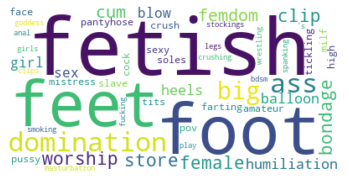

In [24]:
from wordcloud import *
word_freq = [i for i in counter.most_common(50)]
wd = WordCloud(background_color='white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [25]:
train_size = int(data.shape[0] * .8)

train = data[:train_size]
val = data[train_size:]

# Split train and test

X_train = train.text_preprocessed.to_numpy()
y_train = train.labels.to_numpy()

X_val = val.text_preprocessed.to_numpy()
y_val = val.labels.to_numpy()

In [26]:
train.text_preprocessed.to_numpy()

array(['favorite slut', "girlfriends sit 's faces asses",
       'bound beauty kisses girlfriend', ...,
       'watch heather take behind gets banged loves every minute touching balls licking fingers pleasure watch cum shoots cum face letting drip slowly',
       'already website encourage come join fun stop say hi message board www.sockittothepedal.com',
       'e mail us britfet2006 yahoo.co.uk'], dtype=object)

In [27]:
X_train,  y_train

(array(['favorite slut', "girlfriends sit 's faces asses",
        'bound beauty kisses girlfriend', ...,
        'watch heather take behind gets banged loves every minute touching balls licking fingers pleasure watch cum shoots cum face letting drip slowly',
        'already website encourage come join fun stop say hi message board www.sockittothepedal.com',
        'e mail us britfet2006 yahoo.co.uk'], dtype=object),
 array([0, 0, 0, ..., 0, 0, 0]))

In [28]:
X_train.shape, X_val.shape

((48885,), (12222,))

# Tokenize

In [29]:
# vectorize a text corpus by turning each text into sentence of integers

tokenizer2 = Tokenizer(num_words=num_unique_words, oov_token=oov_token)
tokenizer2.fit_on_texts(X_train)

In [30]:
import pickle

# saving
with open('../models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer2, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('../models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [31]:
# each word have a unique index
word_index = tokenizer.word_index
word_index

{'<UNK>': 1,
 'fetish': 2,
 'foot': 3,
 'feet': 4,
 'domination': 5,
 'ass': 6,
 'big': 7,
 'worship': 8,
 'bondage': 9,
 'female': 10,
 'cum': 11,
 'femdom': 12,
 'clip': 13,
 'girl': 14,
 'humiliation': 15,
 'heels': 16,
 'store': 17,
 'balloon': 18,
 'blow': 19,
 'sex': 20,
 'pantyhose': 21,
 'high': 22,
 'milf': 23,
 'sexy': 24,
 'pussy': 25,
 'pov': 26,
 'crush': 27,
 'slave': 28,
 'farting': 29,
 'tits': 30,
 'face': 31,
 'soles': 32,
 'cock': 33,
 'mistress': 34,
 'stockings': 35,
 'amateur': 36,
 'tickling': 37,
 'girls': 38,
 'legs': 39,
 'masturbation': 40,
 'fucking': 41,
 'play': 42,
 'crushing': 43,
 'smoking': 44,
 'goddess': 45,
 'wrestling': 46,
 "'s": 47,
 'spanking': 48,
 'anal': 49,
 'training': 50,
 'clips': 51,
 'socks': 52,
 'bdsm': 53,
 'bubble': 54,
 'tease': 55,
 'lesbian': 56,
 'bbw': 57,
 'fuck': 58,
 'toes': 59,
 'videos': 60,
 'black': 61,
 'video': 62,
 'dirty': 63,
 'hot': 64,
 'boots': 65,
 'shoes': 66,
 'women': 67,
 'hd': 68,
 'leather': 69,
 'woman': 

In [32]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

In [33]:
print(X_train[1])
print(X_train_sequences[1])

girlfriends sit 's faces asses
[1845, 697, 47, 883, 767]


In [34]:
# pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# max words in a sequence
max_length = max([len(x) for x in X_train_sequences]) #256 #20

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding="post", truncating="post")
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding="post", truncating="post")

X_train_padded.shape, X_val_padded.shape


((48885, 8289), (12222, 8289))

In [35]:
X_train_padded[10]

array([ 971, 8801,  273, ...,    0,    0,    0], dtype=int32)

In [36]:
print(X_train[10])
print(X_train_sequences[10])
print(X_train_padded[10])

morgan anytime lick sexy mules clean shoe worship domination
[971, 8801, 273, 24, 987, 949, 83, 8, 5]
[ 971 8801  273 ...    0    0    0]


In [37]:
# Check reversing the indices

# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [38]:
reverse_word_index

{1: '<UNK>',
 2: 'fetish',
 3: 'foot',
 4: 'feet',
 5: 'domination',
 6: 'ass',
 7: 'big',
 8: 'worship',
 9: 'bondage',
 10: 'female',
 11: 'cum',
 12: 'femdom',
 13: 'clip',
 14: 'girl',
 15: 'humiliation',
 16: 'heels',
 17: 'store',
 18: 'balloon',
 19: 'blow',
 20: 'sex',
 21: 'pantyhose',
 22: 'high',
 23: 'milf',
 24: 'sexy',
 25: 'pussy',
 26: 'pov',
 27: 'crush',
 28: 'slave',
 29: 'farting',
 30: 'tits',
 31: 'face',
 32: 'soles',
 33: 'cock',
 34: 'mistress',
 35: 'stockings',
 36: 'amateur',
 37: 'tickling',
 38: 'girls',
 39: 'legs',
 40: 'masturbation',
 41: 'fucking',
 42: 'play',
 43: 'crushing',
 44: 'smoking',
 45: 'goddess',
 46: 'wrestling',
 47: "'s",
 48: 'spanking',
 49: 'anal',
 50: 'training',
 51: 'clips',
 52: 'socks',
 53: 'bdsm',
 54: 'bubble',
 55: 'tease',
 56: 'lesbian',
 57: 'bbw',
 58: 'fuck',
 59: 'toes',
 60: 'videos',
 61: 'black',
 62: 'video',
 63: 'dirty',
 64: 'hot',
 65: 'boots',
 66: 'shoes',
 67: 'women',
 68: 'hd',
 69: 'leather',
 70: 'woma

In [39]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

decoded_text = decode(X_train_sequences[10])

print(X_train_sequences[10])
print(decoded_text)

[971, 8801, 273, 24, 987, 949, 83, 8, 5]
morgan anytime lick sexy mules clean shoe worship domination


In [40]:
# Create LSTM model
from tensorflow.keras import layers

# Word embeddings give us a way to use an efficient, dense representation in which similar words have
# a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a 
# dense vector of floating point values (the length of the vector is a parameter you specify)

# tf.debugging.set_log_device_placement(True)

model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length))

# The layer will take as input as integer matrix of size (batcg, input_length)
# and the largest integer (i.e. word index) in the input should be no larger than num_words (vocabulary size).
# Now model.output_shape is (None, input_length, 32), where `None` is the batch dimension.

model.add(layers.LSTM(64, dropout=.1))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8289, 32)          1473824   
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,498,721
Trainable params: 1,498,721
Non-trainable params: 0
_________________________________________________________________


In [41]:
from pathlib import Path
path = Path('../models/bad_words.model')
path.mkdir(exist_ok=True) 
cpt_filename = '{epoch:02d}_checkpoint_{val_loss:.2f}.hdf5'
cpt_path = str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_loss', verbose=1, 
                                                save_best_only=True, mode='min')

In [42]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = keras.optimizers.legacy.Adam(learning_rate=.001)
metrics = ['accuracy']

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [43]:
model.fit(X_train_padded, y_train, epochs=15, validation_data=(X_val_padded, y_val), verbose=1, 
          callbacks=[checkpoint])

Epoch 1/15
1528/1528 [==============================] - ETA: 0s - loss: 0.1533 - accuracy: 0.9654
Epoch 1: val_loss improved from inf to 0.04581, saving model to ../models/bad_words.model/01_checkpoint_0.05.hdf5
1528/1528 [==============================] - 915s 598ms/step - loss: 0.1533 - accuracy: 0.9654 - val_loss: 0.0458 - val_accuracy: 0.9962
Epoch 2/15
1528/1528 [==============================] - ETA: 0s - loss: 0.1494 - accuracy: 0.9659
Epoch 2: val_loss did not improve from 0.04581
1528/1528 [==============================] - 921s 603ms/step - loss: 0.1494 - accuracy: 0.9659 - val_loss: 0.0492 - val_accuracy: 0.9962
Epoch 3/15
1528/1528 [==============================] - ETA: 0s - loss: 0.1492 - accuracy: 0.9659
Epoch 3: val_loss improved from 0.04581 to 0.04447, saving model to ../models/bad_words.model/03_checkpoint_0.04.hdf5
1528/1528 [==============================] - 927s 607ms/step - loss: 0.1492 - accuracy: 0.9659 - val_loss: 0.0445 - val_accuracy: 0.9962
Epoch 4/15
1528/

In [44]:
# model.get_weights()

In [45]:
history_df = pd.DataFrame(model.history.history)
history_df.head(15)

,loss,accuracy,val_loss,val_accuracy
0,0.153251,0.965388,0.045814,0.996236
1,0.149379,0.965879,0.049223,0.996236
2,0.149235,0.965879,0.044468,0.996236
3,0.149079,0.965879,0.040070,0.996236
4,0.149213,0.965879,0.041867,0.996236
5,0.149108,0.965879,0.050695,0.996236
6,0.149041,0.965879,0.051291,0.996236
7,0.149203,0.965879,0.045692,0.996236
8,0.149016,0.965879,0.045672,0.996236
9,0.149180,0.965879,0.043612,0.996236


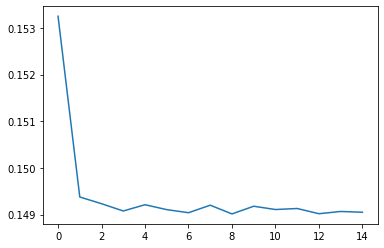

In [46]:
import matplotlib.pyplot as plt
plt.plot(history_df.loss);

In [49]:
model.load_weights('../models/bad_words.model/04_checkpoint_0.04.hdf5') # loading weights - model had created erlier
loss, acc = model.evaluate(X_val_padded, y_val)
print(f'Accuracy of restored model {acc*100:.2f}%')

ValueError: in user code:

    File "/Users/adwiz/miniconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1852, in test_function  *
        return step_function(self, iterator)
    File "/Users/adwiz/miniconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1836, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/adwiz/miniconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1824, in run_step  **
        outputs = model.test_step(data)
    File "/Users/adwiz/miniconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1788, in test_step
        y_pred = self(x, training=False)
    File "/Users/adwiz/miniconda3/envs/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/adwiz/miniconda3/envs/tf/lib/python3.8/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 256), found shape=(None, 8289)


In [50]:
model = tf.keras.models.load_model('../models/bad_words.model/04_checkpoint_0.04.hdf5')
loss, acc = model.evaluate(X_val_padded, y_val)
print(f'Accuracy of restored model {acc*100:.2f}%')

382/382 [==============================] - 47s 121ms/step - loss: 0.0401 - accuracy: 0.9962
Accuracy of restored model 99.62%


In [51]:
!ls '../models/bad_words.model'

01_checkpoint_0.03.hdf5 03_checkpoint_0.05.hdf5 08_checkpoint_0.02.hdf5
01_checkpoint_0.05.hdf5 04_checkpoint_0.03.hdf5 09_checkpoint_0.02.hdf5
02_checkpoint_0.05.hdf5 04_checkpoint_0.04.hdf5 10_checkpoint_0.02.hdf5
03_checkpoint_0.03.hdf5 06_checkpoint_0.02.hdf5
03_checkpoint_0.04.hdf5 07_checkpoint_0.02.hdf5


In [52]:
predictions = model.predict(X_train_padded)
predictions = [1 if p > .5 else 0 for p in predictions]

1528/1528 [==============================] - 192s 125ms/step


In [53]:
X_train_padded[0]

array([2921,  116,    0, ...,    0,    0,    0], dtype=int32)

In [54]:
print(X_train[2000:2010])
print(y_train[2000:2010])
print(predictions[2000:2010])

['make erection go away wmv hd' 'hentai girl3'
 'elegant close-up marlboro reds vinyl leather nose exhales long drag high heels'
 'made cum twice sexy toes day' 'hardcore anal exploration endoscope'
 'amazon daria big sexy feet footstool face foot worship ignore'
 'psychologist cures' 'hentai girl4' 'romantic fucking husband'
 'conflicted mov']
[0 0 0 0 0 0 0 0 0 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [55]:
train['predictions'] = predictions
train = train[['text_preprocessed', 'labels', 'predictions', 'text']] # columns reorder

In [56]:
train.head()

,text_preprocessed,labels,predictions,text
0,favorite slut,0,0,My Favorite Slut
1,girlfriends sit 's faces asses,0,0,girlfriends sit on each other's faces with the...
2,bound beauty kisses girlfriend,0,0,bound beauty kisses her girlfriend
3,morgan anytime nail painting slave 's face,0,0,MORGAN - Anytime - Nail Painting On The Slave'...
4,transgender coaching wmv part 1,0,0,TRANSGENDER COACHING (wmv) PART 1


In [ ]:
train.to_csv('../datasets/wo_html.csv')

In [62]:
model.save('../models/modelSequential_wo_HTML.h5')

In [63]:
# model_new = keras.models.load_model('../models/modelSequential_wo_HTML.h5')
model_new = keras.models.load_model('../models/bad_words.model/04_checkpoint_0.04.hdf5')

In [64]:
predictions = model_new.predict(X_train_padded)
predictions = [1 if p > .5 else 0 for p in predictions]

1528/1528 [==============================] - 191s 125ms/step


# Check sentence

In [65]:
raw_text = "Welcome to Jandro The Tickler. What \
          you're seeing here is completely real! So here's the premise: Husbands, \
          boyfriends, friends, etc, hire me, \"The Tickler\", to show \
          up at a specified location at a specific time with one mission: Find \
          the girl, tie her up, surprise her, and tickle the hell out of her! \
          Sometimes the girls are in the know, and sometimes they're not:) The \
          bonds are real, the reactions are certainly real, and the tickle tools \
          are 100% real. The end result is usually a surprised, shocked, tortured, \
          turned on, worn out girl, with hardly the strength to wave at the camera \
          before I exit:) I basically wanted to combine Tickle Torture with Foot, \
          Sleepy, Voyeur, Light Bondage, and even Forced O. The premise allows \
          all of these to take place per vid."
test_text_preprocessed = bs(raw_text, 'lxml').get_text().replace('\r\n',' ')
test_text_preprocessed = preprocess(test_text_preprocessed, punctuation_marks, stop_words)
test_text_np = np.array([test_text_preprocessed])
test_sequences = tokenizer.texts_to_sequences(test_text_np)

In [66]:
print(test_text_preprocessed)
print(test_sequences[0])

welcome jandro tickler 're seeing completely real 's premise husbands boyfriends friends etc hire tickler '' show specified location specific time one mission find girl tie surprise tickle hell sometimes girls know sometimes 're bonds real reactions certainly real tickle tools 100 real end result usually surprised shocked tortured turned worn girl hardly strength wave camera exit basically wanted combine tickle torture foot sleepy voyeur light bondage even forced o. premise allows take place per vid
[1318, 1, 2001, 2110, 9446, 7239, 201, 47, 1, 3865, 5744, 686, 2349, 7990, 2001, 790, 822, 1, 15687, 10259, 355, 438, 28287, 2297, 14, 833, 2565, 81, 3020, 5322, 38, 1799, 5322, 2110, 5075, 201, 28270, 1, 201, 81, 5621, 1472, 201, 2789, 28012, 1, 14356, 5821, 2148, 2277, 1610, 14, 16798, 3971, 1, 454, 1, 1, 4681, 1, 81, 156, 3, 1383, 175, 1373, 9, 3369, 122, 2699, 1, 27739, 1247, 1824, 1167, 4576]


In [67]:
# for word in test_text_preprocessed:
# Get max training sequence length
max_len = max([len(x) for x in test_sequences])

test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding="post", truncating="post")

In [68]:
print(test_text_preprocessed)
print(test_sequences_padded)

welcome jandro tickler 're seeing completely real 's premise husbands boyfriends friends etc hire tickler '' show specified location specific time one mission find girl tie surprise tickle hell sometimes girls know sometimes 're bonds real reactions certainly real tickle tools 100 real end result usually surprised shocked tortured turned worn girl hardly strength wave camera exit basically wanted combine tickle torture foot sleepy voyeur light bondage even forced o. premise allows take place per vid
[[ 1318     1  2001  2110  9446  7239   201    47     1  3865  5744   686
   2349  7990  2001   790   822     1 15687 10259   355   438 28287  2297
     14   833  2565    81  3020  5322    38  1799  5322  2110  5075   201
  28270     1   201    81  5621  1472   201  2789 28012     1 14356  5821
   2148  2277  1610    14 16798  3971     1   454     1     1  4681     1
     81   156     3  1383   175  1373     9  3369   122  2699     1 27739
   1247  1824  1167  4576]]


In [71]:
%%time
predictions = model_new.predict(test_sequences_padded)
predictions = [1 if p > .5 else 0 for p in predictions]

1/1 [==============================] - 0s 42ms/step
CPU times: user 55.7 ms, sys: 36.2 ms, total: 92 ms
Wall time: 96.5 ms


In [72]:
predictions

[0]

In [ ]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

def preprocess(text, stop_words, punctuation_marks): #, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = token #morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return ' '.join(preprocessed_text)

punctuation_marks = ['!', ',', ';', ':', '(', ')', '-', '--', '?', '@', '....', '~', '¬ß'
                     '.', '..', '...', '....................', '<', '>', '=', '»', '|', '’', '`', '+', '$',
                     '&', '#', '+++', '*', '``', '%', '[', ']', '{', '}', '√©', '√™', '¬†', '√¢']


stop_words = stopwords.words('english') + ['14000kbps', 'https', "'s", "'m", 'http', 'mp4', 'error', '404',
                                          'Error 404', '404error']

# loading
with open('../models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
model = keras.models.load_model('../models/modelSequential_wo_HTML.h5')

raw_text = 'nigger'


def predict(sequences):
    sequences_padded = pad_sequences(sequences, maxlen=max_length, padding="post", truncating="post")
    predictions = model.predict(sequences_padded)
    predictions = [1 if p > .5 else 0 for p in predictions]
    return predictions

# Data loading and preparation
data = pd.read_json('../datasets/neil_ProducerClipSite_rand.json')
mapping = {False: 0, True: 1}
# data.replace({'hasBadWords': mapping}, inplace=True)
# data.hasBadWords = data.hasBadWords.apply(lambda x: 1 if x == True else 0)
# data.rename(columns={"hasBadWords": "labels"}, inplace=True)
data.drop(['SiteID', 'Title', 'Description', 'Keywords', 'Bottom'], axis=1, inplace=True)
data.head()



In [ ]:
data.Top

In [ ]:
%%time
data['text'] = data.apply(lambda row: bs(row.Top, 'lxml').get_text().replace('\r\n',' ').replace('.', ''), axis=1)
data['text_preprocessed'] = data.apply(lambda row: preprocess(row.text, punctuation_marks, stop_words), axis=1)

# Get max training sequence length
max_length = max([len(x) for x in X_val_sequences])

X_val = data.text_preprocessed.to_numpy()
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_val_padded = pad_sequences(X_val_sequences, maxlen=256, padding="post", truncating="post")
# X_val_padded = pad_sequences(X_val_sequences, padding="post", truncating="post")


predictions = model.predict(X_val_padded)
predictions = [1 if p > .5 else 0 for p in predictions]


In [ ]:

X_val_padded[100:102]


In [ ]:
data['predictions'] = predictions

In [ ]:
data.head()

In [ ]:
data = data[['Top', 'predictions']]

In [ ]:
data.to_csv('../datasets/last_one.csv')

In [ ]:
data.to_json('../datasets/last_one.json')